In [ ]:
import os
import hashlib
import shutil
from tqdm import tqdm
from pathlib import Path

# =================配置区域=================
# 你的数据集根目录 (包含 class 0, class 1 等文件夹的那个目录)
DATA_DIR = r"D:\IT\CODE\JUPYTER\ConvNeXt_V2\data" 

# 备份重复文件的目录 (脚本会把重复文件移到这里，而不是直接删除，方便你检查)
BACKUP_DIR = r"D:\IT\CODE\JUPYTER\ConvNeXt_V2\data_duplicates_backup"
# =========================================

def calculate_md5(file_path, chunk_size=8192):
    """计算文件的 MD5 哈希值 (数字指纹)"""
    md5 = hashlib.md5()
    try:
        with open(file_path, 'rb') as f:
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()
    except Exception as e:
        print(f"无法读取文件 {file_path}: {e}")
        return None

def clean_dataset(root_dir, backup_dir):
    # 1. 准备工作
    if not os.path.exists(backup_dir):
        os.makedirs(backup_dir)
        
    # 记录所有唯一的哈希值
    # 格式: { "md5_value": "path/to/first/image.png" }
    unique_hashes = {} 
    
    duplicates_count = 0
    conflict_count = 0 # 跨类冲突计数
    
    # 获取所有图片文件
    print(f"正在扫描目录: {root_dir} ...")
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    
    # 遍历所有子文件夹 (class 0, class 1...)
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        print(f"正在处理类别: {class_name}")
        
        # 遍历该类别下的文件
        files = [f for f in os.listdir(class_path) if os.path.splitext(f)[1].lower() in image_extensions]
        
        for filename in tqdm(files, desc=f"Checking {class_name}"):
            file_path = os.path.join(class_path, filename)
            
            # 计算指纹
            file_hash = calculate_md5(file_path)
            if file_hash is None:
                continue
            
            # 2. 检查是否重复
            if file_hash in unique_hashes:
                original_path = unique_hashes[file_hash]
                original_class = os.path.basename(os.path.dirname(original_path))
                
                # 情况 A: 严重的跨类冲突 (Data Leakage / Label Noise)
                if original_class != class_name:
                    print(f"\n🚨 发现严重冲突! 同一张图出现在不同类别中:")
                    print(f"   图1 ({original_class}): {original_path}")
                    print(f"   图2 ({class_name}): {file_path}")
                    conflict_count += 1
                
                # 移动重复文件到备份目录
                # 保持原来的类别结构
                backup_class_dir = os.path.join(backup_dir, class_name)
                if not os.path.exists(backup_class_dir):
                    os.makedirs(backup_class_dir)
                
                shutil.move(file_path, os.path.join(backup_class_dir, filename))
                duplicates_count += 1
                
            else:
                # 如果没见过这个哈希值，登记下来
                unique_hashes[file_hash] = file_path

    # 3. 总结报告
    print("-" * 60)
    print(f"扫描完成!")
    print(f"✅ 有效唯一图片数: {len(unique_hashes)}")
    print(f"🗑️ 移除非法重复图: {duplicates_count}")
    
    if conflict_count > 0:
        print(f"❌ 警告: 发现 {conflict_count} 个跨类别冲突 (同一张图既是A类又是B类)！")
        print("请检查 duplicates_backup 文件夹，确认保留哪一张。")
    else:
        print("✨ 完美: 没有发现跨类别冲突，数据很干净。")
        
    print(f"重复文件已安全移动到: {backup_dir}")

# 执行清洗
clean_dataset(DATA_DIR, BACKUP_DIR)

step_1

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import os

# ----------------------
# 1. 核心配置
# ----------------------
CONFIG = {
    "num_classes": 4,          # 4类
    "img_size": 256,           # Swin V2 Tiny 分辨率
    "batch_size": 32,          # 显存够大可以改 64
    "data_dir": "./data", # 你的路径
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"当前配置: {CONFIG['num_classes']} 分类, 运行设备: {CONFIG['device']}")

# ----------------------
# 2. 数据增强 (升级版)
# ----------------------

# 【训练集】强数据增强
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG['img_size'], scale=(0.8, 1.0)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 【验证集 & 测试集】普通处理 (只缩放，不乱动)
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ----------------------
# 3. 数据加载
# ----------------------
# 加载两次：一次为了训练(强增强)，一次为了验证/测试(标准处理)
full_train_ds = datasets.ImageFolder(root=CONFIG['data_dir'], transform=train_transforms)
full_val_ds = datasets.ImageFolder(root=CONFIG['data_dir'], transform=val_transforms)

# 打印类别映射
print("类别映射:", full_train_ds.class_to_idx)

# ----------------------
# 4. 划分训练集、验证集、测试集 
# ----------------------
# 计算数量
total_len = len(full_train_ds)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len # 剩下的给测试集

# 设定种子确保切分一致
seed = torch.Generator().manual_seed(42)

# A. 切出训练集 (使用 full_train_ds，带强增强)
train_dataset, _, _ = random_split(full_train_ds, [train_len, val_len, test_len], generator=seed)

seed = torch.Generator().manual_seed(42) # 重置种子，位置对齐

# B. 切出验证集和测试集 (使用 full_val_ds，带标准处理)
_, val_dataset, test_dataset = random_split(full_val_ds, [train_len, val_len, test_len], generator=seed)

# ----------------------
# 5. 创建加载器
# ----------------------
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
# 测试集用于最后写报告，不需要 shuffle
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ 数据加载完毕！")
print(f"训练集: {len(train_dataset)} (强增强)")
print(f"验证集: {len(val_dataset)} (标准)")
print(f"测试集: {len(test_dataset)} (标准 - 用于最终报告)")

当前配置: 4 分类, 运行设备: cuda
类别映射: {'class 0': 0, 'class 1': 1, 'class 2': 2, 'class 3': 3}
✅ 数据加载完毕！
训练集: 4940 (强增强)
验证集: 1058 (标准)
测试集: 1060 (标准 - 用于最终报告)


step_2

In [2]:
import timm
import torch.nn as nn

def get_model(num_classes):
    # 修正点：模型名称改为 'swinv2_tiny_window16_256'
    # 注意：swin和v2中间没有下划线，且窗口大小通常是16
    model_name = 'swinv2_tiny_window16_256'
    
    print(f"正在加载模型: {model_name} (分类数: {num_classes})...")
    
    try:
        model = timm.create_model(
            model_name, 
            pretrained=True, 
            num_classes=num_classes
        )
    except Exception as e:
        # 如果还是报错，我们会尝试列出所有可用模型，帮助排查
        print(f"报错了！正在查找可用的 Swin V2 模型...")
        all_models = timm.list_models('*swinv2*')
        print("您当前安装的 timm 支持以下 Swin V2 模型:", all_models[:5]) # 只打印前5个
        raise e

    model = model.to(CONFIG['device'])
    return model

# 重新运行模型构建
model = get_model(CONFIG['num_classes'])
print("模型加载成功！")

d:\IT\CONDA\envs\SV2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


正在加载模型: swinv2_tiny_window16_256 (分类数: 4)...
模型加载成功！


step_3

 开始 Fine-tuning 训练... 设备: cuda
Epoch 1 [Val  ]: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s, acc=85.26%, loss=0.5873]
-->  发现新高! 保存模型 (Val Acc: 85.26%)
Epoch 1 结束. Train Loss: 0.6755 | Val Acc: 85.26%
------------------------------------------------------------
Epoch 2 [Val  ]: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s, acc=86.20%, loss=0.5785]
-->  发现新高! 保存模型 (Val Acc: 86.20%)
Epoch 2 结束. Train Loss: 0.5842 | Val Acc: 86.20%
------------------------------------------------------------
Epoch 3 [Val  ]: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s, acc=85.92%, loss=0.5777]
Epoch 3 结束. Train Loss: 0.5640 | Val Acc: 85.92%
------------------------------------------------------------
Epoch 4 [Val  ]: 100%|██████████| 34/34 [00:30<00:00,  1.12it/s, acc=86.48%, loss=0.5744]
-->  发现新高! 保存模型 (Val Acc: 86.48%)
Epoch 4 结束. Train Loss: 0.5530 | Val Acc: 86.48%
------------------------------------------------------------
Epoch 5 [Val  ]: 100%|██████████| 34/34 [00:11<00:00,  2.99it/s, ac

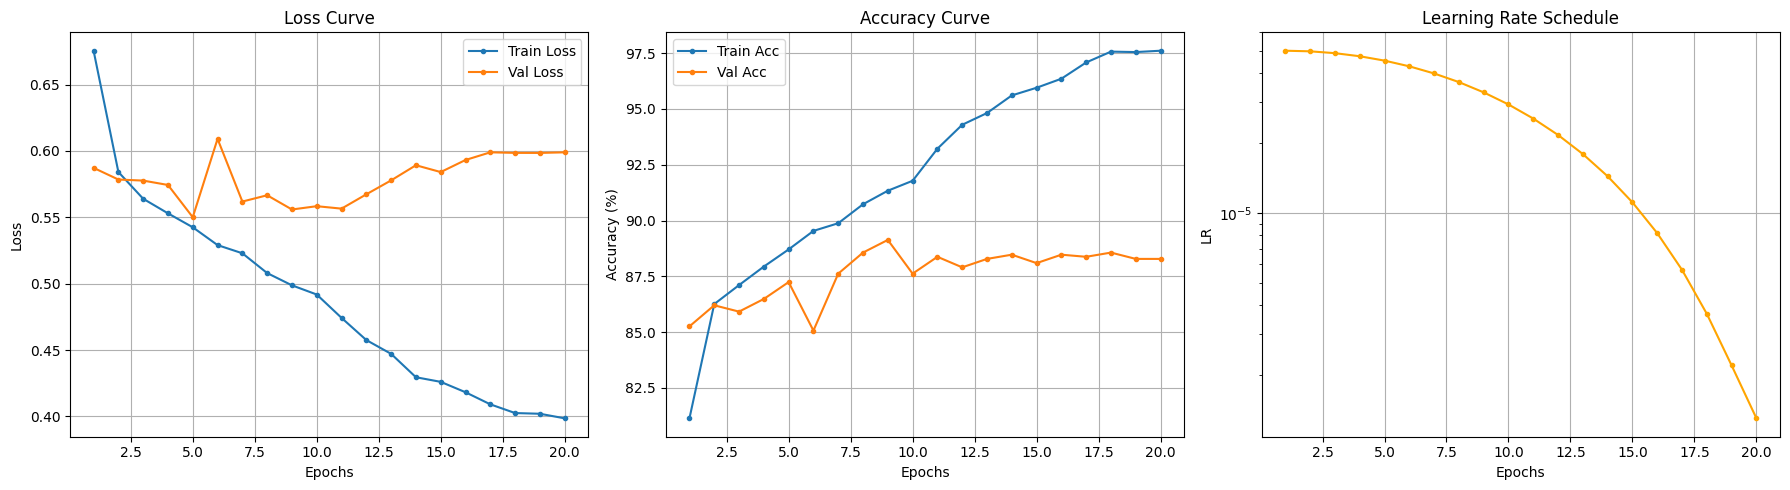

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt  # <--- 1. 引入绘图库

# ----------------------
# (之前的准备工作代码保持不变) ...
# ----------------------
# 假设 model, train_loader, val_loader, CONFIG 已经在上下文中定义好
# 这里为了代码完整性，保留核心变量定义

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)
EPOCHS = 20 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
scaler = torch.amp.GradScaler('cuda')

# ----------------------
# 定义训练与验证函数 (保持你的原逻辑不变)
# ----------------------
def train_one_epoch(epoch_index, model, loader, optimizer, criterion, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 获取当前学习率用于显示
    current_lr = optimizer.param_groups[0]['lr']
    
    loop = tqdm(loader, desc=f"Epoch {epoch_index} [Train]", file=sys.stdout)
    
    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        current_avg_loss = running_loss / (batch_idx + 1)
        loop.set_postfix(loss=f"{current_avg_loss:.4f}", acc=f"{100.*correct/total:.2f}%", lr=f"{current_lr:.1e}")
        
    return running_loss / len(loader), 100. * correct / total

def validate(epoch_index, model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    loop = tqdm(loader, desc=f"Epoch {epoch_index} [Val  ]", file=sys.stdout)
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loop):
            images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            current_avg_loss = val_loss / (batch_idx + 1)
            loop.set_postfix(loss=f"{current_avg_loss:.4f}", acc=f"{100.*correct/total:.2f}%")
            
    return val_loss / len(loader), 100. * correct / total

# ----------------------
# 2. 准备历史数据容器
# ----------------------
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'lr': []
}

# ----------------------
# 开始正式训练
# ----------------------
best_acc = 0.0

print(f" 开始 Fine-tuning 训练... 设备: {CONFIG['device']}")

for epoch in range(1, EPOCHS + 1):
    # 记录当前学习率 (在 step 之前记录)
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)

    # 训练 & 验证
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion, scheduler)
    val_loss, val_acc = validate(epoch, model, val_loader, criterion)
    
    # 更新学习率
    scheduler.step()
    
    # ----------------------
    # 3. 记录数据到 List
    # ----------------------
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_finetuned.pth")
        print(f"-->  发现新高! 保存模型 (Val Acc: {val_acc:.2f}%)")
        
    print(f"Epoch {epoch} 结束. Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 60)

print(f"训练完成！最高准确率: {best_acc:.2f}%")

# ----------------------
# 4. 训练结束后绘图
# ----------------------
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 设置画布大小：宽18，高5
    plt.figure(figsize=(18, 5))
    
    # 图1：Loss 曲线
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='.')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='.')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 图2：Accuracy 曲线
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', marker='.')
    plt.plot(epochs, history['val_acc'], label='Val Acc', marker='.')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # 图3：Learning Rate 曲线
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['lr'], label='Learning Rate', color='orange', marker='.')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epochs')
    plt.ylabel('LR')
    plt.yscale('log') # 因为 LR 变化幅度大，用对数坐标显示更清晰
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png') # 保存为图片
    plt.show() # 显示出来

# 调用绘图函数
plot_training_history(history)

In [ ]:
# ----------------------
# Step 3.5: 最终测试 (升级版 - 含分各类别准确率)
# ----------------------
def final_test(model, loader, device, class_names):
    # --- 1. 加载最佳权重 ---
    if os.path.exists("best_model_finetuned.pth"):
        model.load_state_dict(torch.load("best_model_finetuned.pth", map_location=device))
        print("已加载最佳模型权重 (best_model_finetuned.pth)")
    elif os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth", map_location=device))
        print("已加载最佳模型权重 (best_model.pth)")
    else:
        print("警告: 没找到保存的模型文件，正在使用当前权重！")

    model.eval()
    
    # --- 2. 初始化计数器 ---
    # class_correct: 记录每一类猜对了几张
    # class_total:   记录每一类一共有几张
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    
    total_correct = 0
    total_samples = 0
    
    print(f"正在进行最终测试 (共 {len(loader.dataset)} 张图片)...")
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            # 开启混合精度加速
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
            
            _, predicted = outputs.max(1)
            
            # --- 3. 统计整体准确率 ---
            total_samples += labels.size(0)
            total_correct += predicted.eq(labels).sum().item()
            
            # --- 4. 统计每一类的准确率 ---
            # 将 tensor 转为 list 方便处理
            c = (predicted == labels).squeeze()
            
            for i in range(len(labels)):
                label = labels[i].item()      # 获取真实标签的索引 (0, 1, 2...)
                is_correct = c[i].item()      # 获取是否预测正确 (True/False)
                
                class_correct[label] += is_correct
                class_total[label] += 1

    # --- 5. 输出报告 ---
    print("\n" + "="*40)
    print("最终测试报告 (Final Report)")
    print("="*40)
    
    # 打印每一类的表现
    for i in range(len(class_names)):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f"类别 [{class_names[i]:<10}]: {acc:>6.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
        else:
            print(f"类别 [{class_names[i]:<10}]: 无测试样本")
            
    # 打印整体准确率
    overall_acc = 100. * total_correct / total_samples
    print("-" * 40)
    print(f"整体准确率 (Overall Acc): {overall_acc:.2f}%")
    print("="*40)
    
    return overall_acc

# 获取类别名称列表
# 注意：因为你是用 random_split 切分的，test_dataset 本身没有 classes 属性
# 我们需要从它的父级 dataset (full_val_ds 或 full_train_ds) 获取类别名称
class_names = full_train_ds.classes 

# 执行测试
final_test(model, test_loader, CONFIG['device'], class_names)

✅ 已加载最佳模型权重 (best_model_finetuned.pth)
正在进行最终测试 (共 1060 张图片)...


Testing: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


🎯 最终测试报告 (Final Report)
类别 [class 0   ]:  94.03% (378/402)
类别 [class 1   ]:  66.98% (142/212)
类别 [class 2   ]:  98.08% (204/208)
类别 [class 3   ]: 100.00% (238/238)
----------------------------------------
🏆 整体准确率 (Overall Acc): 90.75%


90.75471698113208

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import pandas as pd
from tqdm import tqdm

# 确保模型处于 eval 模式并加载最佳权重
device = CONFIG['device']
model = get_model(CONFIG['num_classes']) # 重新实例化结构
weight_path = "best_model_finetuned.pth" if os.path.exists("best_model_finetuned.pth") else "best_model.pth"

if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    print(f"成功加载权重: {weight_path}")
else:
    print("未找到权重文件，使用随机初始化模型（可视化将无意义）")

model.eval()
model.to(device)

# 定义一个获取所有预测结果和特征的函数
def get_predictions_and_features(model, loader, device):
    all_preds = []
    all_labels = []
    all_features = []
    
    # 注册 Hook 来获取全连接层之前的特征向量 (用于 t-SNE)
    # Timm 的 SwinV2 通常在 model.head 之前是特征
    features_list = []
    def hook_fn(module, input, output):
        # input[0] 是进入分类头之前的特征，维度通常是 [Batch, Num_Features]
        features_list.append(input[0].detach().cpu())
    
    # 注册 forward hook
    handle = model.head.register_forward_hook(hook_fn)
    
    print("正在提取测试集特征和预测结果...")
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            
            # 混合精度推理
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 移除 hook
    handle.remove()
    
    # 合并特征
    all_features = torch.cat(features_list, dim=0).numpy()
    
    return np.array(all_preds), np.array(all_labels), all_features

# 执行提取 (使用测试集)
y_pred, y_true, features = get_predictions_and_features(model, test_loader, device)

正在加载模型: swinv2_tiny_window16_256 (分类数: 4)...
✅ 成功加载权重: best_model_finetuned.pth
正在提取测试集特征和预测结果...


100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


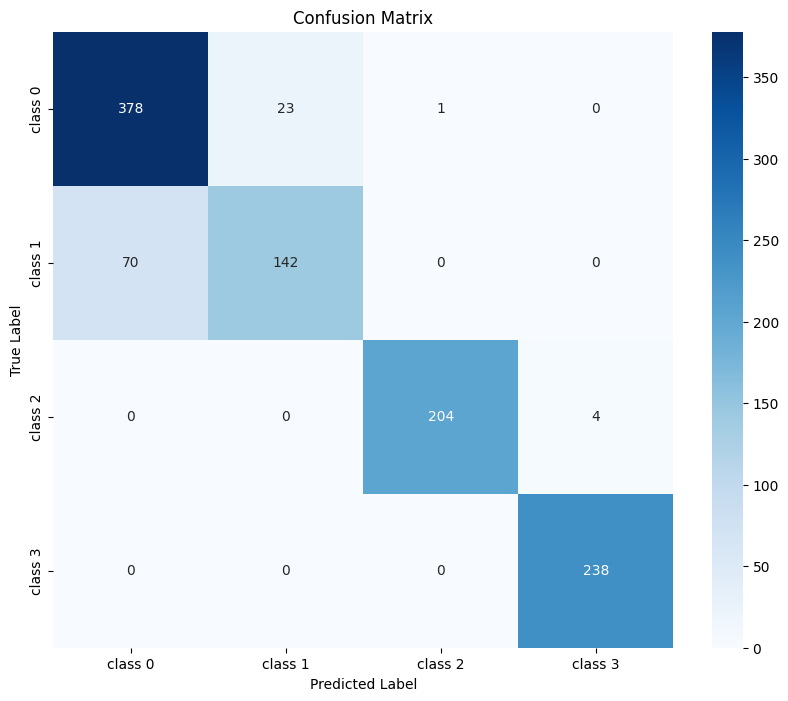


分类详细报告:

              precision    recall  f1-score   support

     class 0     0.8438    0.9403    0.8894       402
     class 1     0.8606    0.6698    0.7533       212
     class 2     0.9951    0.9808    0.9879       208
     class 3     0.9835    1.0000    0.9917       238

    accuracy                         0.9075      1060
   macro avg     0.9207    0.8977    0.9056      1060
weighted avg     0.9082    0.9075    0.9045      1060



In [7]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 计算百分比形式（可选）
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # 打印详细报告
    print("\n分类详细报告:\n")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# 获取类别名称
class_names = [k for k, v in sorted(full_train_ds.class_to_idx.items(), key=lambda item: item[1])]

# 绘图
plot_confusion_matrix(y_true, y_pred, class_names)

正在提取测试集特征和预测结果 (修正版)...


100%|██████████| 34/34 [00:11<00:00,  3.09it/s]


特征提取完毕，特征维度: (1060, 768)
正在计算 t-SNE (可能需要一点时间)...


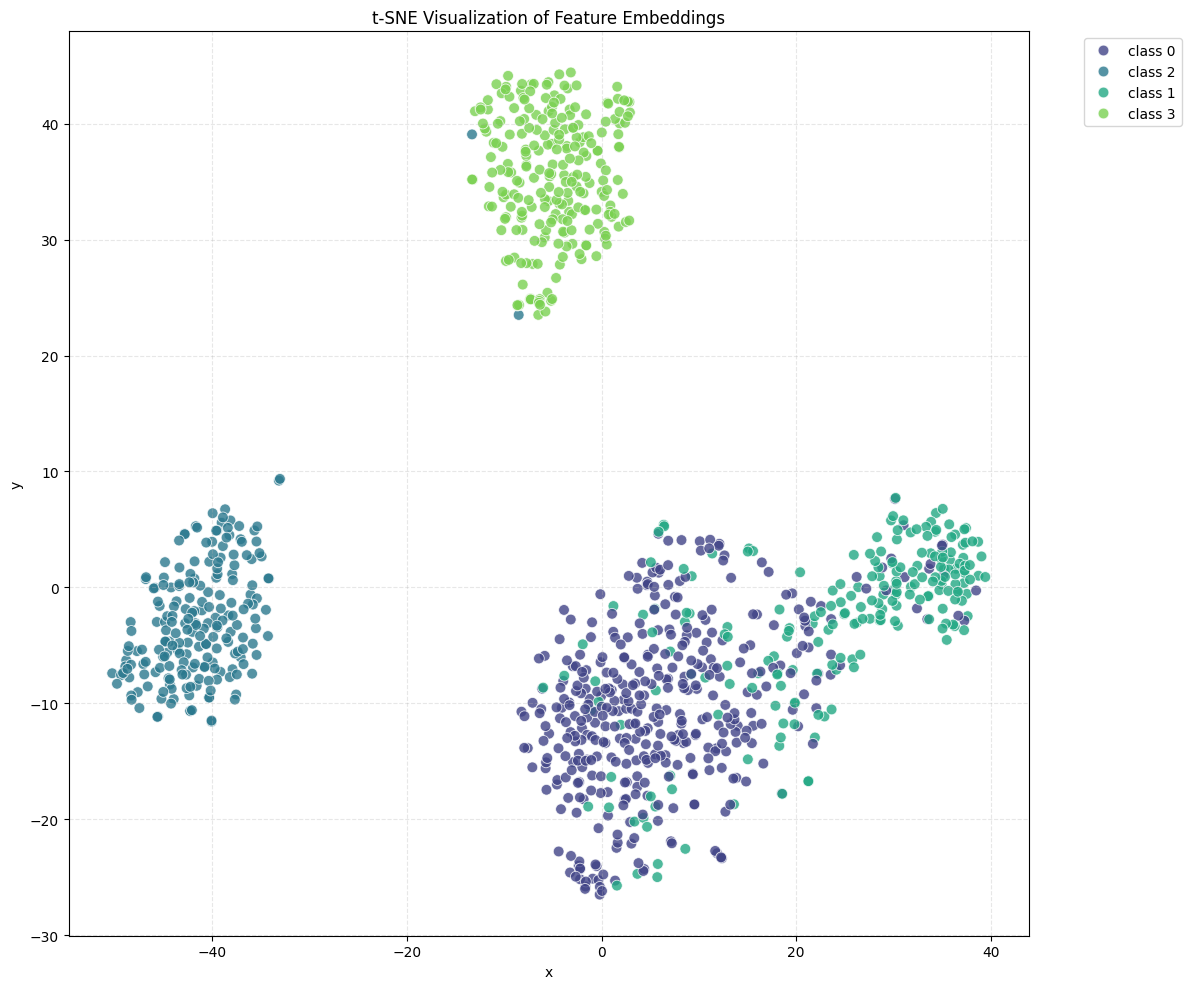

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# ----------------------
# 修正版特征提取函数
# ----------------------
def get_predictions_and_features(model, loader, device):
    all_preds = []
    all_labels = []
    features_list = []
    
    # 定义 Hook 函数
    def hook_fn(module, input, output):
        # input[0] 是进入分类头之前的特征
        feat = input[0].detach() # 移除梯度
        
        # --- 核心修正：手动执行全局平均池化 ---
        # 如果特征是 4维 [B, C, H, W] 或 [B, H, W, C]，需要变成 [B, C]
        if feat.ndim == 4:
            # 这里的 swin 通常输出可能是 NCHW，直接对 H,W 维度求平均
            # 无论 [B, C, H, W] 还是 [B, H, W, C]，只要把最后两个空间维度平均掉通常就对了
            # 但为了保险，我们使用 adaptive_avg_pool2d (针对 NCHW)
            # 如果是 Swin 的 NHWC，timm 通常在送入 head 前已经 permute 成 NCHW 了
            if feat.shape[1] < feat.shape[2] and feat.shape[1] < feat.shape[3]:
                 # 这种通常是 NCHW (Channel 在第1维，且数值较小)
                 feat = F.adaptive_avg_pool2d(feat, (1, 1)).flatten(1)
            else:
                 # 这种可能是 NHWC，直接对 [1, 2] 求平均
                 feat = feat.mean(dim=[1, 2])
                 
        elif feat.ndim == 3:
            # 针对 Vision Transformer [B, L, C]，取 CLS token 或平均
            # SwinV2 如果输出 3维通常是 [B, L, C]，直接平均
            feat = feat.mean(dim=1)
            
        features_list.append(feat.cpu())
    
    # 注册 Hook
    handle = model.head.register_forward_hook(hook_fn)
    
    model.eval()
    print("正在提取测试集特征和预测结果 (修正版)...")
    
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            
            # 混合精度推理
            with torch.amp.autocast('cuda', dtype=torch.float16):
                outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 移除 Hook，防止内存泄漏
    handle.remove()
    
    # 合并特征 [Total_Samples, Feature_Dim]
    all_features = torch.cat(features_list, dim=0).numpy()
    
    return np.array(all_preds), np.array(all_labels), all_features

# 1. 重新运行提取
y_pred, y_true, features = get_predictions_and_features(model, test_loader, CONFIG['device'])

# 2. 检查维度是否正确 (应该是 2维，例如 [1060, 768])
print(f"特征提取完毕，特征维度: {features.shape}")

# 3. 再次尝试绘图
if features.ndim == 2:
    plot_tsne(features, y_true, class_names)
else:
    print("错误：特征维度依然不对，请检查模型结构。")

🖼️ 正在处理: 1083.png


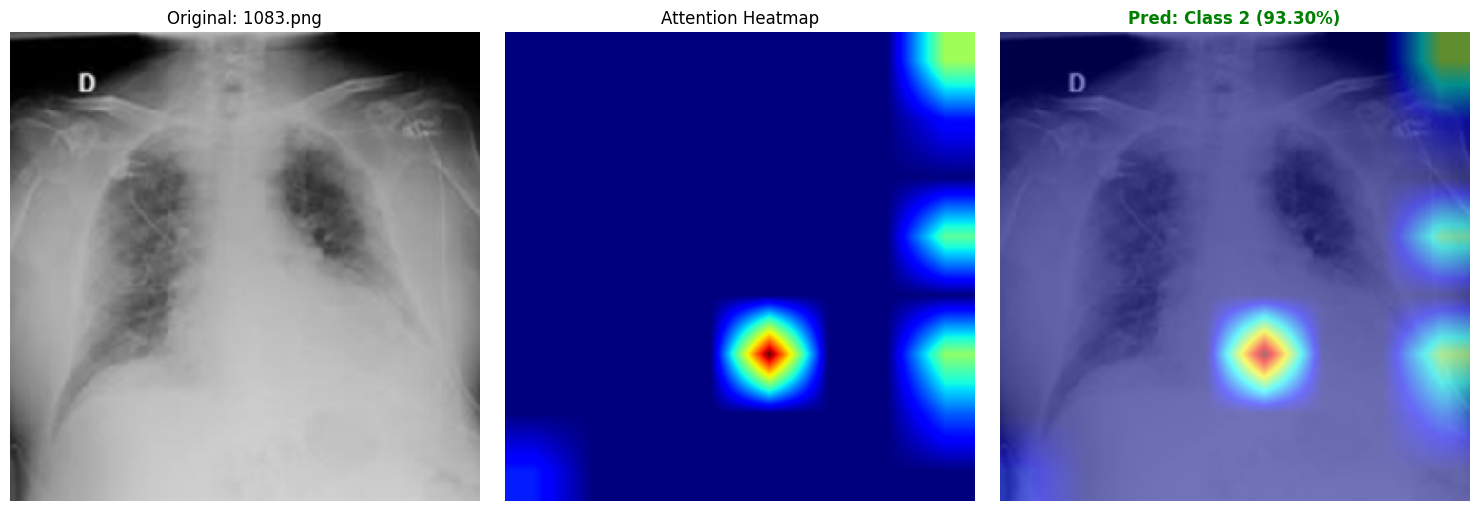

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ------------------------------------------
# 1. Swin V2 专用的维度变换函数
# ------------------------------------------
def swin_reshape_transform(tensor):
    """
    Swin 的输出通常是 (Batch, H, W, C) 或 (Batch, L, C)。
    Grad-CAM 需要 (Batch, C, H, W)。
    """
    # 情况 A: [B, H, W, C] -> 调整为 [B, C, H, W]
    if tensor.ndim == 4:
        return tensor.permute(0, 3, 1, 2)

    # 情况 B: [B, L, C] -> 恢复 H,W -> 调整为 [B, C, H, W]
    if tensor.ndim == 3:
        B, L, C = tensor.shape
        H = W = int(L ** 0.5)  # 假设输入是正方形
        return tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
        
    return tensor

# ------------------------------------------
# 2. 核心可视化函数 (标准模型版)
# ------------------------------------------
def visualize_gradcam(model, img_path, device):
    print(f"🖼️ 正在处理: {os.path.basename(img_path)}")
    
    # --- A. 确定目标层 (直接针对 timm Swin V2) ---
    # Swin 的结构通常是 layers -> blocks -> norm
    # 我们选取最后一个 Stage 的最后一个 Block 的第一个 Norm 层
    try:
        target_layers = [model.layers[-1].blocks[-1].norm1]
    except AttributeError:
        # 如果报错，可能是 timm 版本差异，尝试用最后的 norm 层兜底
        print("⚠️ 没找到 layers[-1].blocks[-1]，尝试使用 model.norm ...")
        target_layers = [model.norm]

    # --- B. 初始化 Grad-CAM ---
    # use_cuda=True if device=='cuda' else False (新版库会自动处理)
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=swin_reshape_transform)

    # --- C. 图片预处理 ---
    img_pil = Image.open(img_path).convert('RGB')
    
    # 1. 制作显示的底图 (归一化到 0-1 的 float32)
    img_vis = np.array(img_pil.resize((CONFIG['img_size'], CONFIG['img_size']))) / 255.0
    
    # 2. 制作输入 Tensor
    input_tensor = val_transforms(img_pil).unsqueeze(0).to(device)

    # --- D. 生成热力图 ---
    # 注意：Swin V2 在 float16 下计算梯度可能会不稳定，如果报错，建议临时转 float32
    # 这里我们不做 autocast，直接运行
    targets = None # None 表示自动找概率最大的那一类
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # --- E. 获取预测结果 ---
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_conf = probs[0][pred_idx].item()
    
    # 获取类别名称 (假设是数字)
    class_name = str(pred_idx)

    # --- F. 绘图 (三联图) ---
    visualization = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(15, 5))
    
    # 1. 原图
    plt.subplot(1, 3, 1)
    plt.imshow(img_vis)
    plt.title(f"Original: {os.path.basename(img_path)}")
    plt.axis('off')
    
    # 2. 热力图
    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.title("Attention Heatmap")
    plt.axis('off')
    
    # 3. 叠加图
    plt.subplot(1, 3, 3)
    plt.imshow(visualization)
    plt.title(f"Pred: Class {class_name} ({pred_conf:.2%})", color='green', fontweight='bold')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------
# 3. 执行测试
# ------------------------------------------
# 确保您的 model 已经定义并加载了权重
# model = get_model(CONFIG['num_classes']) # 如果之前还没定义
# model.load_state_dict(...)

import glob
import random

# 搜索目录下的图片
search_pattern = os.path.join(CONFIG['data_dir'], "**", "*.[jp][pn]g") 
found_files = glob.glob(search_pattern, recursive=True)

if len(found_files) > 0:
    # 随机挑一张图
    sample_path = random.choice(found_files)
    visualize_gradcam(model, sample_path, CONFIG['device'])
else:
    print("⚠️ 没找到图片，请检查路径。")